## Import libraries

In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from scipy.spatial.distance import euclidean
import warnings
from scipy.spatial.distance import pdist
warnings.filterwarnings("ignore")

## Loading the preproccessed dataset

In [2]:
data = pd.read_csv("311project_data.csv")
data.head()

,income,recency,wine_num,fruit_num,meat_num,fish_num,sweet_num,gold_num,dis_num,web_num,...,visit_num,complain,accept_last,age,total_spent,children,family_size,is_parent,education,total_accepted
0,58138.0,58,635,88,546,172,88,88,3,8,...,7,0,1,66,1617,0,1,0,Graduate,0
1,46344.0,38,11,1,6,2,1,6,2,1,...,5,0,0,69,27,2,3,1,Graduate,0
2,71613.0,26,426,49,127,111,21,42,1,8,...,4,0,0,58,776,0,2,0,Graduate,0
3,26646.0,26,11,4,20,10,3,5,2,2,...,6,0,0,39,53,1,3,1,Graduate,0
4,58293.0,94,173,43,118,46,27,15,5,5,...,5,0,0,42,422,1,3,1,Postgraduate,0


## Feature Engineering

In [3]:
def col_names(dataframe, cat_th=10, car_th=200):
    #categorical columns
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "bool", "object"]]
    #columns that seem numerical but actually categorical
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_cols = cat_cols + num_but_cat
    #numerical columns
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols

cat_cols, num_cols = col_names(data)

In [4]:
# split the data with numerical and categorical columns
X_num = data[num_cols]
X_cat = data[cat_cols]

#Apply standard scaler to scale the data
scaler = StandardScaler()
X_num_standardized = scaler.fit_transform(X_num)

n=3
# For dimentionality reduction, apply pca.
pca_num = PCA(n_components=n)
X_num_pca = pca_num.fit_transform(X_num_standardized)

# Apply One-Hot Encoding to encode the categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
X_cat_encoded = encoder.fit_transform(X_cat)

# Combine numerical PCA components with the categorical features
X_combined = np.concatenate([X_num_pca, X_cat_encoded], axis=1)

pca_columns = [f"PC{i + 1}" for i in range(n)]
encoded_cat_columns = encoder.get_feature_names_out(X_cat.columns)
combined_columns = np.concatenate([pca_columns, encoded_cat_columns])
df_combined = pd.DataFrame(data=X_combined, columns=combined_columns)

In [5]:
encoded_cat_columns = encoder.get_feature_names_out(X_cat.columns)

In [6]:
combined_columns = np.concatenate([pca_columns, encoded_cat_columns])

In [7]:
df_combined = pd.DataFrame(data=X_combined, columns=combined_columns)
df_combined

,PC1,PC2,PC3,education_Postgraduate,education_Undergraduate,complain_1,accept_last_1,children_1,children_2,children_3,family_size_2,family_size_3,family_size_4,family_size_5,is_parent_1,total_accepted_1,total_accepted_2,total_accepted_3,total_accepted_4
0,4.055673,0.654354,0.664766,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-2.259297,-0.599172,-1.368735,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.701497,0.149578,-0.067521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-2.549330,-0.713555,1.008697,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.114561,0.475005,0.584618,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2.874986,1.214539,1.396873,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2236,-0.704576,3.099037,-1.566115,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2237,1.429577,-0.168991,-0.147046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2238,1.976400,0.290152,-0.753442,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# KMEANS
* The k-means method is a popular clustering technique used in data analysis for partitioning a dataset into distinct groups (clusters) based on similarities among the data points. This algorithm assigns each point to the nearest cluster center, iteratively optimizing the positions of the centers to minimize the variance within each cluster.
## choosing n_clusters
* Although the score is lower than for two clusters, choosing three clusters might provide a more meaningful segmentation that balances distinctiveness with detail.

In [8]:
# Try different numbers of clusters and evaluate silhouette scores
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df_combined)
    silhouette_avg = silhouette_score(df_combined, clusters)
    print(f"For n_clusters={n_clusters}, the silhouette score is {silhouette_avg:.2f}")

For n_clusters=2, the silhouette score is 0.42
For n_clusters=3, the silhouette score is 0.33
For n_clusters=4, the silhouette score is 0.26
For n_clusters=5, the silhouette score is 0.20
For n_clusters=6, the silhouette score is 0.19
For n_clusters=7, the silhouette score is 0.19
For n_clusters=8, the silhouette score is 0.20
For n_clusters=9, the silhouette score is 0.20
For n_clusters=10, the silhouette score is 0.18


In [9]:
# Apply K-Means clustering with n_clusters=3
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_combined)
df_kmeans=df_combined.copy()
df_kmeans["Cluster"] = labels

# MULTIPLE KMEANS ENSEMBLE ALGORITHM
* The multiple k-means algorithm enhances the traditional k-means clustering approach by running the algorithm multiple times with different initializations, thereby addressing the issue of k-means' sensitivity to initial cluster placements. This ensemble technique results in a more robust clustering solution, as it aggregates the outcomes of these multiple runs to identify the most consistent and representative cluster structures within the data.

In [11]:
def multiple_kmeans_clustering(data, n_clusters, n_iterations):
    """
    Apply multiple kmeans clustering

    """
    labels = []
    silhouette_scores = []

    for _ in range(n_iterations):
        kmeans = KMeans(n_clusters=n_clusters, init='random', n_init=1)
        cluster_labels = kmeans.fit_predict(data)
        score = silhouette_score(data, cluster_labels)

        labels.append(cluster_labels)
        silhouette_scores.append(score)

    return labels, silhouette_scores

def analyze_cluster_relations(labels, n_samples):
    """
    create a co-occurrence matrix that shows if the instance is in the same clusters in different iterations of kmeans.
    """
    co_occurrence_matrix = np.zeros((n_samples, n_samples))

    for label_set in labels:
        for i in range(n_samples):
            for j in range(n_samples):
                if label_set[i] == label_set[j]:
                    co_occurrence_matrix[i, j] += 1

    co_occurrence_matrix /= len(labels)
    return co_occurrence_matrix

def final_object_assignments(co_occurrence_matrix, kmeans_labels, threshold=0.5):
    """
    assigns each instance to the clusters
    
    """
    n_samples = co_occurrence_matrix.shape[0]
    final_assignments = np.full(n_samples, -1)  # Initialize with -1 (considered as noise)

    for i in range(n_samples):
        # Initialize a dictionary to count co-occurrences for each cluster label
        label_counts = {label: 0 for label in range(n_clusters)}

        # Iterate over all kmeans labels and update counts based on co-occurrence matrix
        for label_set in kmeans_labels:
            for j, label in enumerate(label_set):
                if co_occurrence_matrix[i, j] >= threshold:
                    label_counts[label] += co_occurrence_matrix[i, j]

        # Assign to the label with the highest count
        if label_counts:
            final_assignments[i] = max(label_counts, key=label_counts.get)

    return final_assignments

#create final clusters
n_clusters = 3
n_iterations = 20
kmeans_labels, silhouette_scores = multiple_kmeans_clustering(df_combined, n_clusters, n_iterations)
co_occurrence_matrix = analyze_cluster_relations(kmeans_labels, len(df_combined))
final_clusters = final_object_assignments(co_occurrence_matrix, kmeans_labels, threshold=0)

df_multiple_kmeans=df_combined.copy()
df_multiple_kmeans["cluster"]=final_clusters

In [12]:
silhouette_scores

[0.3269003455025921,
 0.32839597629408407,
 0.3269003455025921,
 0.32839597629408407,
 0.3269003455025921,
 0.32839597629408407,
 0.3269003455025921,
 0.3269003455025921,
 0.3269003455025921,
 0.3269003455025921,
 0.32839597629408407,
 0.3269003455025921,
 0.32839597629408407,
 0.3269003455025921,
 0.3269003455025921,
 0.32839597629408407,
 0.32738065593997245,
 0.3269003455025921,
 0.3269003455025921,
 0.32839597629408407]

In [13]:
np.unique(df_multiple_kmeans["cluster"])

array([0, 1, 2])

# Meta-Clustering Ensemble scheme
* The Meta-Clustering Ensemble scheme,involves applying multiple clustering algorithms or iterations to a dataset and then analyzing the relationships between the resulting clusters to form meta-clusters. This approach aims to enhance the robustness and accuracy of clustering by combining the strengths of various clustering methods and capturing a more comprehensive understanding of the underlying data patterns.

In [14]:
#using different linkage criteria as different methods
linkage_methods = ['ward', 'complete', 'average', 'single']
primary_clusters = [AgglomerativeClustering(linkage=method).fit_predict(df_combined) for method in linkage_methods]

def calculate_similarity(cluster1_labels, cluster2_labels):
    """
    Calculate similarity between two clusters
    """
    #find shared instances between two clusters
    shared_instances = np.intersect1d(np.where(cluster1_labels == 1)[0], np.where(cluster2_labels == 1)[0])
    proportion_shared = len(shared_instances) / (len(np.where(cluster1_labels == 1)[0]) + len(np.where(cluster2_labels == 1)[0]))
    size_factor = min(len(np.where(cluster1_labels == 1)[0]), len(np.where(cluster2_labels == 1)[0])) / max(len(np.where(cluster1_labels == 1)[0]), len(np.where(cluster2_labels == 1)[0]))

    similarity = proportion_shared * size_factor

    return similarity

#calculate similarities between all pairs of primary clusters
similarity_matrix = np.zeros((len(primary_clusters), len(primary_clusters)))
for i in range(len(primary_clusters)):
    for j in range(i+1, len(primary_clusters)):
        similarity = calculate_similarity(primary_clusters[i], primary_clusters[j])
        similarity_matrix[i, j] = similarity_matrix[j, i] = similarity

#create Meta-Clusters
if len(similarity_matrix.shape) == 1:
    similarity_matrix_2d = squareform(similarity_matrix)
else:
    similarity_matrix_2d = similarity_matrix

meta_cluster_model = AgglomerativeClustering(n_clusters=3)
meta_clusters = meta_cluster_model.fit_predict(similarity_matrix_2d)

similarity_threshold = 0.4
merged_clusters = []

for i in range(len(meta_clusters)):
    for j in range(i + 1, len(meta_clusters)):
        if similarity_matrix_2d[i, j] >= similarity_threshold:
            merged_clusters.append((i, j))

unique_clusters = set()
for pair in merged_clusters:
    unique_clusters.update(pair)

n_optimal_clusters = len(unique_clusters)
print(f"Optimal number of clusters after merging: {n_optimal_clusters}")


Optimal number of clusters after merging: 2


In [15]:
n_clusters=n_optimal_clusters

def calculate_instance_to_cluster_similarity(instance, cluster_data):
    """
    Calculate the similarity of an instance to a cluster based on average Euclidean distance.
    """
    instance = np.array(instance)
    avg_distance = np.mean([euclidean(instance, point) for point in cluster_data])

    similarity = 1 / avg_distance if avg_distance > 0 else float('inf')#inverse of distance gives the similarity
    return similarity


distance_matrix = 1 - similarity_matrix
np.fill_diagonal(distance_matrix, 0)

similarity_threshold = 0.5

meta_cluster_model = AgglomerativeClustering(n_clusters=n_clusters)
meta_clusters = meta_cluster_model.fit_predict(distance_matrix)

final_cluster_assignments = np.zeros(len(df_combined))

primary_to_meta = {}
for i, method_clusters in enumerate(primary_clusters):
    for cluster_label in set(method_clusters):
        primary_to_meta[(i, cluster_label)] = meta_clusters[i]

#assign each instance to a meta-cluster
for i, instance in enumerate(df_combined.to_numpy()):
    meta_cluster_similarities = np.zeros(n_clusters)

    for j, method_clusters in enumerate(primary_clusters):
        primary_cluster_label = method_clusters[i]
        meta_cluster_label = primary_to_meta[(j, primary_cluster_label)]
        cluster_instances = df_combined.to_numpy()[np.array(method_clusters) == primary_cluster_label]

        # calculates similarities of the instances to the current meta-cluster
        similarity = calculate_instance_to_cluster_similarity(instance, cluster_instances)
        meta_cluster_similarities[meta_cluster_label] += similarity
        final_cluster_assignments[i] = np.argmax(meta_cluster_similarities)

final_cluster_assignments = final_cluster_assignments.astype(int)

print("Cluster assignment distribution:", np.bincount(final_cluster_assignments))
df_mcems = df_combined.copy()
df_mcems['cluster'] = final_cluster_assignments



Cluster assignment distribution: [2170   70]


#### In conclusion, while the implementation of the MCEMS method based on the article was carefully attempted, the final outcome did not meet the expected results due to persistent challenges in cluster assignments and similarity calculations. This experience highlights the complexities inherent in advanced clustering techniques and the importance of considering data characteristics and methodological nuances.*

# Agglomerative Clustering
* Agglomerative clustering is a hierarchical clustering method that iteratively merges data points or existing clusters based on their proximity, starting with each point as a separate cluster and combining them until all points are merged into a single cluster or a stopping criterion is met. This bottom-up approach uses linkage criteria, such as minimum distance, average distance, or maximum distance, to determine the similarity between clusters, making it effective for revealing nested and multi-scale structures in data.

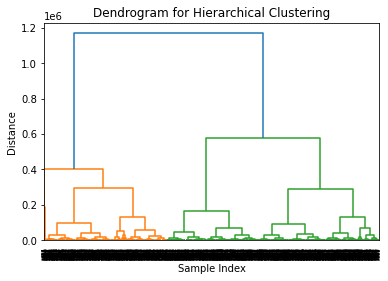

In [16]:
from scipy.cluster.hierarchy import dendrogram, linkage

dendrogram(linkage(X_num, method='ward'))
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

In [17]:
features_for_clustering = ['income', 'recency','total_spent', 'age']
clustering = AgglomerativeClustering(n_clusters=3)
df_agg = data.copy()
df_agg['cluster'] = clustering.fit_predict(df_agg[features_for_clustering])

# Evaluation
### Clustering Results Evaluation

- **K-Means Clustering:** Shows balanced cluster distribution, indicating effective data partitioning.
- **Multiple K-Means Clustering:** Offers more evenly sized clusters, suggesting improved consensus over single runs.
- **Agglomerative Clustering:** Reveals a less pronounced cluster size variance, which may capture more subtle data groupings.

_Excluded MC-EMS due to implementation issues._


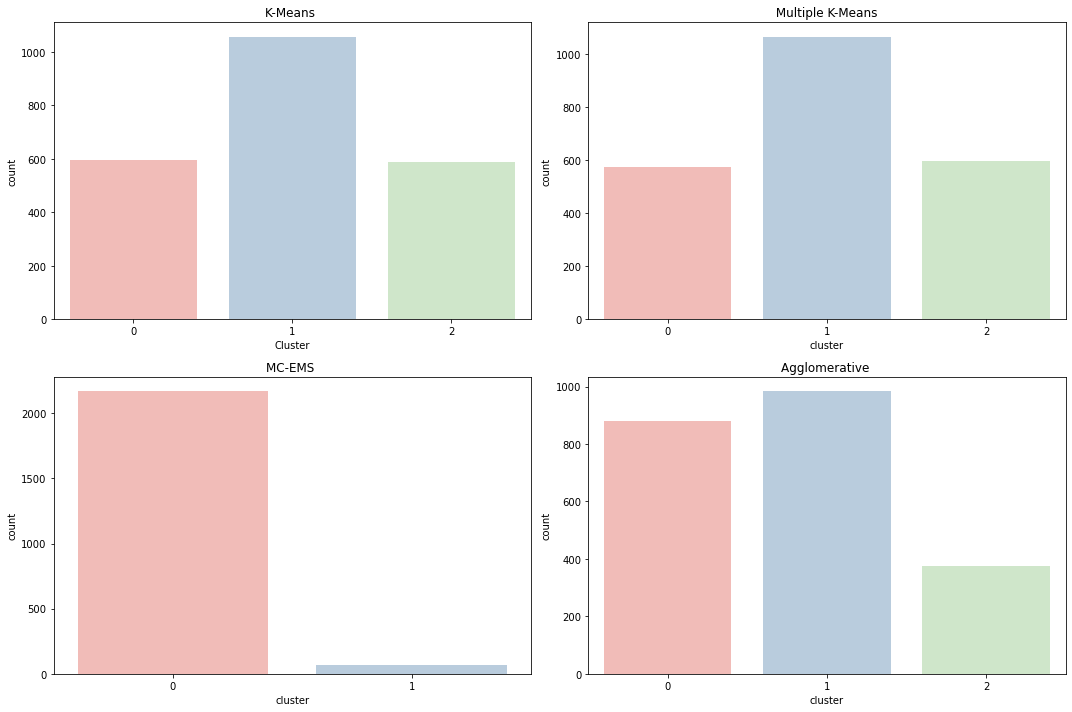

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

def compare_clusters(cluster_kmeans, cluster_mcems, cluster_agglomerative):
    plt.figure(figsize=(15,10))

    # K-Means
    plt.subplot(2, 2, 1)
    sns.countplot(x=cluster_kmeans, palette="Pastel1")
    plt.title('K-Means ')
    
    # Multiple K-Means
    plt.subplot(2, 2, 2)
    sns.countplot(x=df_multiple_kmeans["cluster"], palette="Pastel1")
    plt.title(' Multiple K-Means ')
    # MC-EMS
    plt.subplot(2, 2, 3)
    sns.countplot(x=cluster_mcems, palette="Pastel1")
    plt.title('MC-EMS ')

    # Agglomerative
    plt.subplot(2, 2, 4)
    sns.countplot(x=cluster_agglomerative, palette="Pastel1")
    plt.title('Agglomerative ')

    plt.tight_layout()
    plt.show()

# Usage example:
compare_clusters(df_kmeans["Cluster"], df_mcems["cluster"], df_agg["cluster"])


### Clustering Results Evaluation

- **K-Means Clustering:** Wide income variance; skewed `total_spent` with cluster 1 higher median.
- **Multiple K-Means:** Uniform income distribution; balanced `total_spent` with cluster 2 higher median.
- **Agglomerative Clustering:** Refined income grouping; `total_spent` differentiated, cluster 2 with broader range.

_Multiple K-Means clusters income more uniformly, while Agglomerative better differentiates spending behavior._


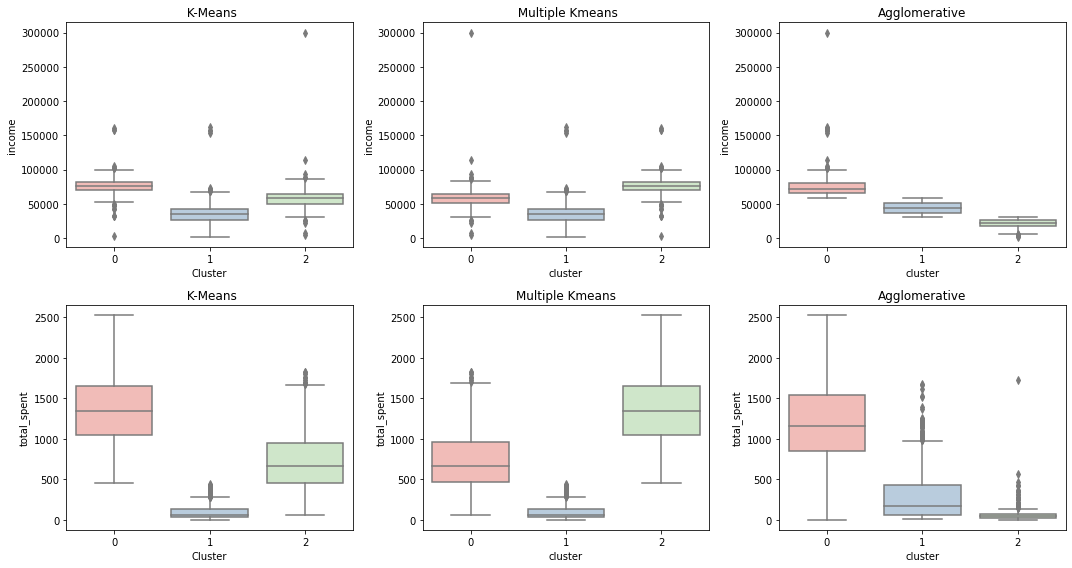

In [19]:
def compare_clusters_boxplot(cluster_kmeans, cluster_multiple_kmeans, cluster_agglomerative):
    plt.figure(figsize=(15,8))

    # Boxplot for 'income' in K-Means
    plt.subplot(2, 3, 1)
    sns.boxplot(x=cluster_kmeans, y='income', data=data, palette="Pastel1")
    plt.title(' K-Means')

    # Boxplot for 'income' in MC-EMS
    plt.subplot(2, 3, 2)
    sns.boxplot(x=cluster_multiple_kmeans, y='income', data=data, palette="Pastel1")
    plt.title(' Multiple Kmeans')

    # Boxplot for 'income' in Agglomerative
    plt.subplot(2, 3, 3)
    sns.boxplot(x=cluster_agglomerative, y='income', data=data, palette="Pastel1")
    plt.title('Agglomerative')
    
    # Boxplot for 'total_spent' in K-Means
    plt.subplot(2, 3, 4)
    sns.boxplot(x=cluster_kmeans, y='total_spent', data=data, palette="Pastel1")
    plt.title(' K-Means')

    # Boxplot for 'total_spent' in MC-EMS
    plt.subplot(2, 3, 5)
    sns.boxplot(x=cluster_multiple_kmeans, y='total_spent', data=data, palette="Pastel1")
    plt.title('Multiple Kmeans')

    # Boxplot for 'total_spent' in Agglomerative
    plt.subplot(2, 3, 6)
    sns.boxplot(x=cluster_agglomerative, y='total_spent', data=data, palette="Pastel1")
    plt.title('Agglomerative')
    
    

    plt.tight_layout()
    plt.show()

# Usage example:
compare_clusters_boxplot(df_kmeans["Cluster"],df_multiple_kmeans["cluster"], df_agg["cluster"])

### K-Means Clustering Results
The K-Means clustering results show a distinct separation between clusters for the `PC1` feature, indicating strong differentiation in that principal component. Clusters 0 and 1 overlap significantly in `PC2` and `PC3`, suggesting similarities in these components. Cluster 2 appears to be well-separated from the others across all principal components.

### Multiple K-Means Clustering Results
Multiple K-Means clustering exhibits a more homogeneous distribution among the clusters, especially for `PC1` and `PC2`. However, `PC3` shows some separation, particularly for cluster 2 which is more dispersed compared to the other clusters.

### Agglomerative Clustering Results
Agglomerative clustering presents clusters with overlapping regions in all principal components, with cluster 2 demonstrating higher variance. This indicates a less distinct separation between clusters, potentially suggesting that Agglomerative clustering captures more nuanced relationships between data points.


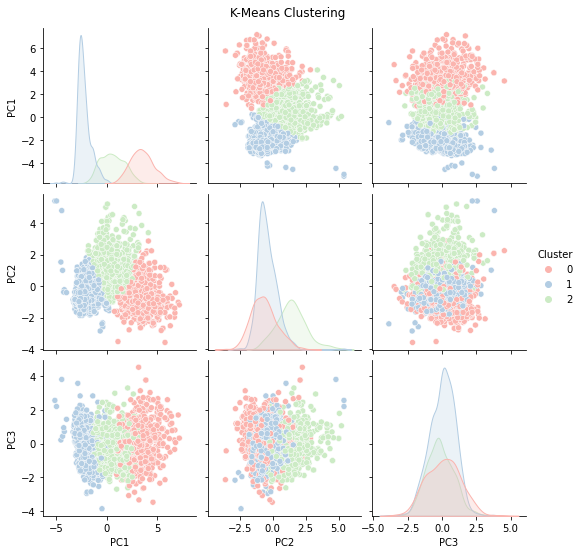

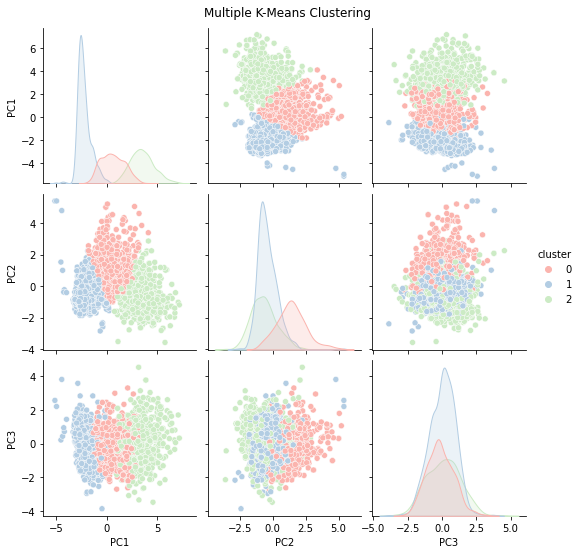

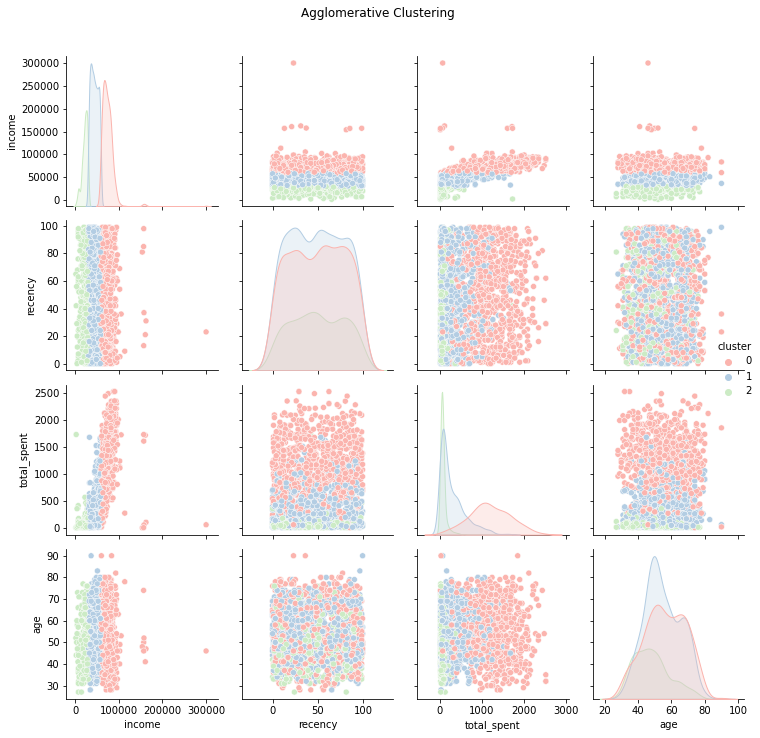

In [20]:
def compare_clusters_pairplot(cluster_kmeans, cluster_multiple_kmeans, cluster_agglomerative):
    features_for_clustering = ['income', 'recency', 'total_spent', 'age']
    varrs = ["PC1", "PC2", "PC3"]
    
    # Pairplot for K-Means
    grid_kmeans = sns.pairplot(cluster_kmeans, vars=varrs, hue='Cluster', palette='Pastel1')
    grid_kmeans.fig.suptitle('K-Means Clustering', y=1.02)  

    # Pairplot for Multiple Kmeans
    grid_multiple_kmeans = sns.pairplot(cluster_multiple_kmeans, vars=varrs, hue='cluster', palette='Pastel1')
    grid_multiple_kmeans.fig.suptitle('Multiple K-Means Clustering', y=1.02)

    # Pairplot for Agglomerative
    grid_agglomerative = sns.pairplot(cluster_agglomerative, vars=features_for_clustering, hue='cluster', palette='Pastel1')
    grid_agglomerative.fig.suptitle('Agglomerative Clustering', y=1.02)

    plt.tight_layout()
    plt.show()

compare_clusters_pairplot(df_kmeans, df_multiple_kmeans, df_agg)


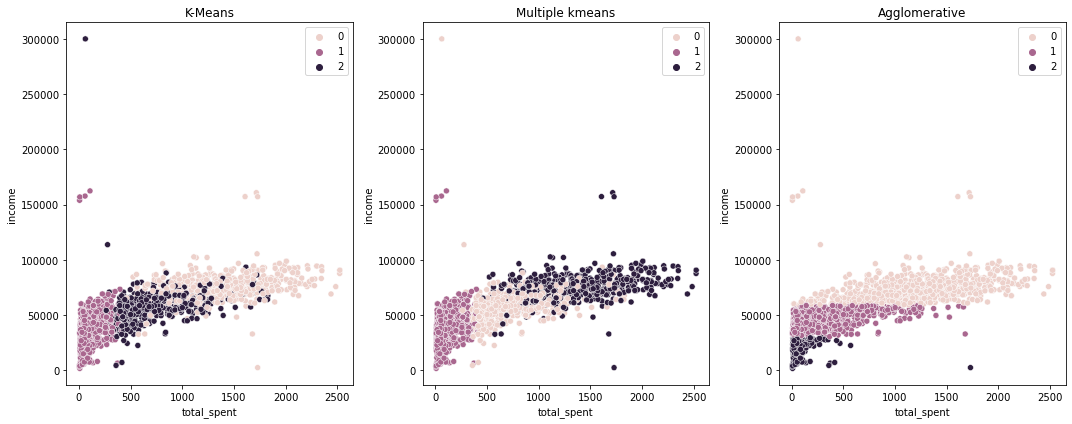

In [21]:
def compare_clusters_scatterplot(cluster_kmeans, cluster_multiple_kmeans, cluster_agglomerative):
    plt.figure(figsize=(15, 6))

    # Scatterplot for K-Means
    plt.subplot(1, 3, 1)
    pl_kmeans = sns.scatterplot(data=data, x=data["total_spent"], y=data["income"], hue=cluster_kmeans)
    pl_kmeans.set_title("K-Means")
    plt.legend()

    # Scatterplot for MC-EMS
    plt.subplot(1, 3, 2)
    pl_mcems = sns.scatterplot(data=data, x=data["total_spent"], y=data["income"], hue=cluster_multiple_kmeans)
    pl_mcems.set_title("Multiple kmeans")
    plt.legend()

    # Scatterplot for Agglomerative
    plt.subplot(1, 3, 3)
    pl_agglomerative = sns.scatterplot(data=data, x=data["total_spent"], y=data["income"], hue=cluster_agglomerative)
    pl_agglomerative.set_title("Agglomerative")
    plt.legend()


    plt.tight_layout()
    plt.show()

compare_clusters_scatterplot(df_kmeans["Cluster"], df_multiple_kmeans["cluster"], df_agg["cluster"])

### Silhouette Score Comparison

- **K-Means**: Achieves a silhouette score of `0.3269`, indicating a fair amount of separation and cohesion within the clusters. This suggests that while there's some overlap, the clusters are reasonably well-defined.

- **Multiple K-Means**: With a higher silhouette score of `0.3681`, this indicates better cluster definition and separation than the standard K-Means. The ensemble approach may be capturing more robust structures within the data.

- **Agglomerative Clustering**: The silhouette score of `0.1121` is significantly lower, suggesting that the clusters have more overlap and less distinction between them, which might indicate that the method is capturing more subtle and complex structures.


In [22]:
def compare_clusters_silhouette(cluster_kmeans, cluster_multiple_kmeans, cluster_agglomerative):
    
    silhouette_kmeans = silhouette_score(df_combined, cluster_kmeans)
    silhouette_multiple_kmeans = silhouette_score(df_combined, cluster_multiple_kmeans)
    silhouette_agglomerative = silhouette_score(df_combined, cluster_agglomerative)

    print("silhouette score of kmeans:" ,silhouette_kmeans)
    print("silhouette score of multiple kmeans:" ,silhouette_multiple_kmeans)
    print("silhouette score of agglomerative clustering:" ,silhouette_agglomerative)
    


# Usage example:
compare_clusters_silhouette(df_kmeans["Cluster"], df_multiple_kmeans["cluster"], df_agg["cluster"])

silhouette score of kmeans: 0.3269003455025921
silhouette score of multiple kmeans: 0.32720436117331536
silhouette score of agglomerative clustering: 0.11210506916792938


## Trying to get better results for Multiple Kmeans
* Increasing the number of iterations and increasing the threshold didn't work

In [ ]:
n_iterations=30
th=0.4

kmeans_labels, silhouette_scores = multiple_kmeans_clustering(df_combined, n_clusters, n_iterations)
co_occurrence_matrix = analyze_cluster_relations(kmeans_labels, len(df_combined))
final_clusters = final_object_assignments(co_occurrence_matrix, kmeans_labels, threshold=th)

df_multiple_kmeans_updated=df_combined.copy()
df_multiple_kmeans_updated["cluster"]=final_clusters

In [ ]:
silhouette_score(df_combined, df_multiple_kmeans_updated["cluster"])

## Interpreting the Results

In [ ]:
data["cluster"]=df_multiple_kmeans["cluster"]

In [ ]:
data.columns

## Cluster 0 (1057 customers)
### Income:
The average income in this cluster is approximately 35,316 dollars , with a wide range of incomes (minimum /1,730 to maximum 162,397 dollars). The standard deviation is quite large (14,529 dollars) , indicating significant income variability within this cluster.
### Total Spent:
The average total spent is around 99 dollars, which is relatively low. This suggests that customers in this cluster might be more price-sensitive or less engaged in terms of spending.
### Age: 
The average age is around 51 years, with a standard deviation of 11 years. This cluster might represent middle-aged customers who are relatively consistent in their age distribution.
## Cluster 1 (597 customers)
### Income:
This cluster has a higher average income of about 75,794 dollars, with a narrower income range compared to Cluster 0. The standard deviation is lower (11,935 dollars), indicating more homogeneity in income levels.
### Total Spent: 
Customers in this cluster spend significantly more on average (1,376 dollars), which might indicate a premium customer segment that is less sensitive to price and more focused on quality or luxury.
### Age: 
The average age is slightly higher at 54 years, with a broader age distribution (std dev of 13 years). This cluster might include older, more affluent customers.
## Cluster 2 (586 customers)
### Income: 
The average income here is 57,947 dollars, which is higher than Cluster 0 but lower than Cluster 1. The income range is quite extensive, from 4,428 dollars to 300,000 dollars, suggesting a diverse group in terms of financial standing.
### Total Spent:
The spending average (734 dollars) is higher than Cluster 0 but lower than Cluster 1. This could represent a mid-tier customer segment that balances price and quality.
### Age:
The average age is the highest among the three clusters at 58 years, with a somewhat narrower age distribution. This cluster might represent older customers who are potentially in a stable financial position.
## Overall Insights:
* Cluster 0 could be seen as a '*value-conscious*' segment, with lower income and spending but a broad age range. Marketing strategies for this group could focus on affordability and value deals.
* Cluster 1 seems to represent a '*premium*' segment with higher income and spending habits. Targeted marketing for luxury or high-quality products and services might resonate well with this group.
* Cluster 2 appears to be a '*balanced*' segment, with moderate income and spending. Products and services offering a balance of quality and cost could appeal to this group.

In [ ]:
key_variables = ['income', 'total_spent', 'age']

cluster_descriptive_stats = data.groupby('cluster')[key_variables].describe()

print(cluster_descriptive_stats)

for variable in key_variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=variable, data=data)
    plt.title(f'Distribution of {variable} across Clusters')
    plt.show()


# Shopping habits of the customers

## Wine Purchases (wine_num):
### Cluster 0:
Lower wine purchases with an average of around 44 units. This aligns with the earlier observation of this cluster being more value-conscious.
### Cluster 1:
Significantly higher wine purchases, averaging 604 units, indicative of a premium customer segment with a preference for wine.
### Cluster 2:
Moderate wine purchases, averaging 467 units, suggesting this cluster enjoys wine but to a lesser extent than Cluster 1.
## Fruit Purchases (fruit_num):
### Cluster 0:
Minimal fruit purchases (average of 5 units), again reflecting a more budget-conscious or less engaged group.
### Cluster 1:
High fruit purchases (average of 69 units), possibly indicating a preference for healthier options or a higher willingness to spend on perishables.
### Cluster 2: 
Moderate level of fruit purchases (average of 21 units), higher than Cluster 0 but significantly lower than Cluster 1.
## Meat Purchases (meat_num):
### Cluster 0:
Lower average meat purchases (23 units), consistent with their overall lower spending.
### Cluster 1:
Very high meat purchases (average 453 units), which might be indicative of a preference for premium or gourmet food options.
### Cluster 2: 
Moderate meat purchases (average 135 units), fitting the profile of a mid-tier segment.
## Visit Frequency (visit_num):
### Cluster 0:
Higher frequency of visits (average of 6.38 visits), which might indicate regular but smaller shopping trips.
### Cluster 1:
Less frequent visits (average of 2.85 visits), perhaps due to bulk buying or a focus on specific high-quality products.
### Cluster 2: 
Moderate frequency of visits (average of 5.92 visits), aligning with their balanced spending behavior.
## Discount Usge (dis_num)
### Cluster 0 
shows a moderate response to discounts. Considering their overall lower spending habits, they might be looking for value deals.
### Cluster 1 
seems less motivated by discounts, which aligns with their premium customer profile. Marketing strategies for this cluster might focus more on exclusivity or quality rather than price reductions.
### Cluster 2 
appears to be the most responsive to discount offers. Tailored promotions and discounts could be effective in driving sales and loyalty within this segment.



## General Observations:
* Cluster 0 is characterized by lower spending across categories, frequent visits, and a focus on value. They might be more price-sensitive and might prefer budget or promotional items.
* Cluster 1 represents a high-value segment, spending significantly across various categories, especially on premium items like wine and meat, but with less frequent store visits. This group may be targeted with high-end, luxury, or gourmet products.
* Cluster 2 falls in between, showing moderate spending habits and visit frequency. This group could be receptive to a balanced mix of quality and price in products.

In [ ]:
key_variables = ['wine_num', 'fruit_num', 'meat_num', 'fish_num',
       'sweet_num', 'gold_num', 'dis_num', 'web_num', 'cat_num', 'store_num',
       'visit_num'] 

# Calculate descriptive statistics for each cluster
for var in key_variables:
    
    print(var,data.groupby('cluster')[var].describe())


# Visualization of key variables for each cluster
for variable in key_variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=variable, data=data)
    plt.title(f'Distribution of {variable} across Clusters')
    plt.show()

In [ ]:
data.columns

In [ ]:
key_variables = ["children","family_size","is_parent","education"] 

# Calculate descriptive statistics for each cluster
for var in key_variables:
    print(var,data.groupby('cluster')[var].describe())


# Visualization of key variables for each cluster
for variable in key_variables:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='cluster', y=variable, data=data)
    plt.title(f'Distribution of {variable} across Clusters')
    plt.show()

# Using The Insights for Marketing Strategies
## Cluster 0: *The Value-Conscious Segment*
### Targeted Marketing: 
We can focus on price-sensitive marketing strategies. Highlight sales, discounts, and value deals in our communications.
### Product Strategies:
We can offer a range of budget-friendly products or services that cater to this segment's spending capacity.
### Customer Engagement: 
We can develop loyalty programs with small but frequent rewards to encourage repeat purchases. Provide cost-saving tips or budget-friendly solutions in our content marketing.
### Distribution Channels: 
We can prioritize channels that are known for value deals, such as discount stores or online platforms offering sales.

## Cluster 1: *The Premium Segment*
### Exclusive Offers: 
We can create exclusive or limited-edition products that appeal to their desire for quality and luxury.
### Customized Communication: 
We can use personalized marketing strategies. Highlight the quality, exclusivity, and premium aspects of our offerings.
### Loyalty Programs:
We can design loyalty programs that offer high-value rewards, exclusive access to new products, or VIP treatment.
### Customer Experience:
We should ensure a high level of customer service, as this segment likely values personalized and attentive service.
## Cluster 2: *The Balanced Segment*
### Balanced Product Offerings: 
We can offer products that strike a balance between quality and cost. This could include mid-range products that offer good value for money.
### Promotional Strategies: 
We can utilize moderate discounts or bundle offers to attract this segment without focusing solely on low prices or premium costs.
### Content Marketing: 
We can share content that emphasizes both quality and affordability, such as how-to guides for making the most of their purchases.

## Overall Business Strategy
* Customer Insights for Product Development: We should use the insights from each cluster to inform new product development, ensuring that new offerings align with the specific needs and preferences of each segment.
* Segmented Communication Strategy: We should tailor our communication strategies for each segment, using the language and channels that resonate best with them.
* Feedback Loop: Regularly collecting feedback from each customer segment to refine our understanding of their needs and adjust our strategies accordingly.